In [6]:
import numpy as np
import pywt
from scipy.io import loadmat


# Load and normalize the hyperspectral cube
file_path = '5e128x128SphericGFDefaultSNR40.mat'
data = loadmat(file_path)
synthetic_image = data['syntheticImageNoisy']
synthetic_image = synthetic_image / np.max(synthetic_image)


# Reshape the data so that each pixel's spectral data is a 1D vector
vector_data = synthetic_image.reshape(-1, synthetic_image.shape[2])  # Shape: (128*128, 431)


# Perform wavelet transform on the first vector to get the coefficient sizes
sample_vector = vector_data[0]
cA, cD = pywt.dwt(sample_vector, 'bior1.3')  # Use the desired wavelet type


# Initialize cubes based on actual sizes of cA and cD
approximation_cube = np.empty((vector_data.shape[0], cA.shape[0]))
detail_cube = np.empty((vector_data.shape[0], cD.shape[0]))


# Apply wavelet transform to each 1D spectral vector and store coefficients in the cubes
for idx, vector in enumerate(vector_data):
    cA, cD = pywt.dwt(vector, 'bior1.3')  # Perform wavelet transform
    approximation_cube[idx, :] = cA
    detail_cube[idx, :] = cD


# Reshape the coefficient cubes back to spatial dimensions
approximation_cube = approximation_cube.reshape(synthetic_image.shape[0], synthetic_image.shape[1], -1)
detail_cube = detail_cube.reshape(synthetic_image.shape[0], synthetic_image.shape[1], -1)


# Output the shapes to verify
print("Shape of original cube:", synthetic_image.shape)
print("Shape of approximation cube:", approximation_cube.shape)
print("Shape of detail cube:", detail_cube.shape)




Shape of original cube: (128, 128, 431)
Shape of approximation cube: (128, 128, 218)
Shape of detail cube: (128, 128, 218)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Load MATLAB data
mat_data = scipy.io.loadmat('5e128x128SphericGFDefaultSNR40.mat')

# Access the hyperspectral data, ground truth abundances, and endmembers
abundances_gt = mat_data['abundanciesGT']
endmembers_gt = mat_data['endmembersGT']
synthetic_image_noisy = approximation_cube

# Reshape the data for the LSTM model
synthetic_image_noisy = synthetic_image_noisy.reshape((synthetic_image_noisy.shape[0], -1, synthetic_image_noisy.shape[2]))
abundances_gt = abundances_gt.reshape((abundances_gt.shape[0], -1, abundances_gt.shape[2]))

# Convert to PyTorch tensors
synthetic_image_noisy_tensor = torch.Tensor(synthetic_image_noisy)
abundances_gt_tensor = torch.Tensor(abundances_gt)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size)
        self.dense = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dense(x)
        return x

# Instantiate the LSTM model
input_size = synthetic_image_noisy.shape[2]
hidden_size = 128
output_size = abundances_gt.shape[2]

lstm_model = LSTMModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Convert the data to a DataLoader
lstm_dataset = TensorDataset(synthetic_image_noisy_tensor, abundances_gt_tensor)
lstm_loader = DataLoader(lstm_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    total_rmse = 0.0  # Initialize RMSE for the epoch
    for inputs, targets in lstm_loader:
        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Spectral Angle Mapper (SAM) Loss
        normalized_outputs = F.normalize(outputs, p=2, dim=2)
        normalized_targets = F.normalize(targets, p=2, dim=2)
        cos_similarity = F.cosine_similarity(normalized_outputs, normalized_targets, dim=2)
        loss_sam = 1 - cos_similarity.mean()

        # Spectral Information Divergence (SID) Loss
        epsilon = 1e-8
        loss_sid = torch.sum(targets * torch.log((targets + epsilon) / (outputs + epsilon)))

        # Spectral Angle Divergence (SAD) Loss
        sin_similarity = torch.sqrt(1 - cos_similarity**2)
        loss_sad = sin_similarity.mean()

        # Root Mean Squared Error (RMSE) calculation
        rmse = torch.sqrt(loss)

        total_rmse += rmse.item()

    average_rmse = total_rmse / len(lstm_loader)

    # Print the losses at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], MSE Loss: {loss.item():.4f}, SAM: {loss_sam.item():.6f}, SID: {loss_sid.item():.6f}, SAD: {loss_sad.item():.6f}, RMSE: {average_rmse:.6f}')# Evaluate the model on the entire dataset
with torch.no_grad():
    predicted_abundances = lstm_model(synthetic_image_noisy_tensor)

Epoch [1/50], MSE Loss: 0.0772, SAM: 0.385377, SID: nan, SAD: 0.780049, RMSE: 0.288540
Epoch [2/50], MSE Loss: 0.0715, SAM: 0.371404, SID: 3244.107666, SAD: 0.761622, RMSE: 0.268351
Epoch [3/50], MSE Loss: 0.0657, SAM: 0.328657, SID: 2998.562256, SAD: 0.730127, RMSE: 0.260312
Epoch [4/50], MSE Loss: 0.0636, SAM: 0.327101, SID: 2306.189453, SAD: 0.722627, RMSE: 0.253048
Epoch [5/50], MSE Loss: 0.0574, SAM: 0.288357, SID: nan, SAD: 0.675915, RMSE: 0.245208
Epoch [6/50], MSE Loss: 0.0565, SAM: 0.285852, SID: nan, SAD: 0.667706, RMSE: 0.236329
Epoch [7/50], MSE Loss: 0.0512, SAM: 0.248292, SID: nan, SAD: 0.617286, RMSE: 0.226132
Epoch [8/50], MSE Loss: 0.0402, SAM: 0.196351, SID: nan, SAD: 0.553463, RMSE: 0.210277
Epoch [9/50], MSE Loss: 0.0327, SAM: 0.163562, SID: nan, SAD: 0.491018, RMSE: 0.191415
Epoch [10/50], MSE Loss: 0.0293, SAM: 0.143477, SID: nan, SAD: 0.452781, RMSE: 0.175830
Epoch [11/50], MSE Loss: 0.0289, SAM: 0.143356, SID: nan, SAD: 0.439533, RMSE: 0.173095
Epoch [12/50], MS

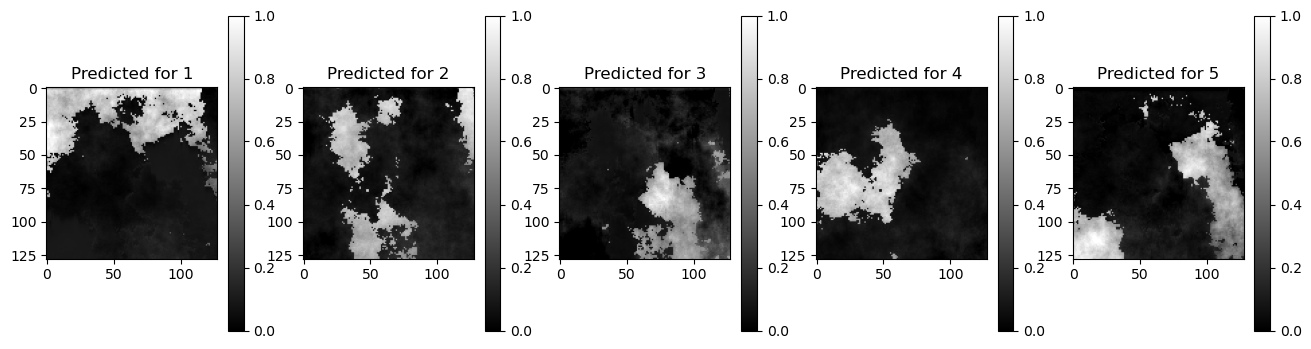

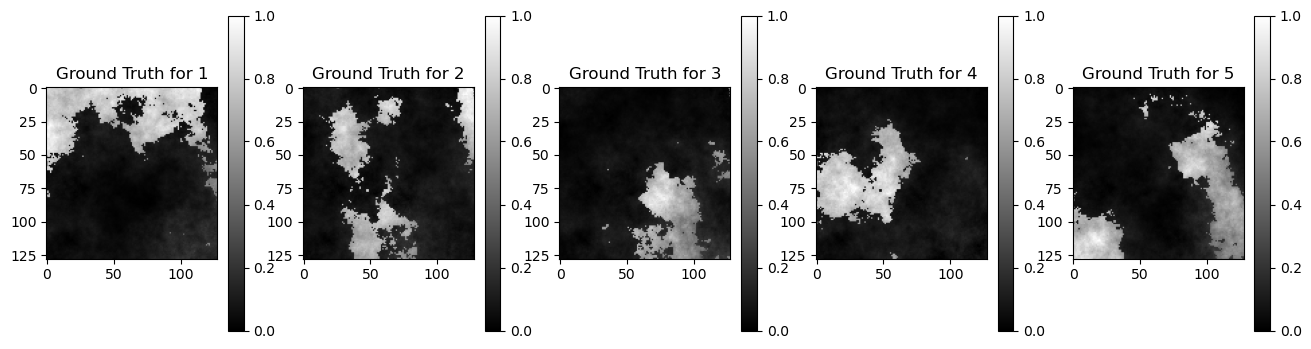

In [8]:
# Display predicted abundance maps in subplots
num_endmembers = abundances_gt.shape[2]
plt.figure(figsize=(16, 9))

for endmember_index in range(num_endmembers):
    plt.subplot(2, num_endmembers, endmember_index + num_endmembers + 1)
    plt.imshow(predicted_abundances[:, :, endmember_index], cmap='gray', vmin=0, vmax=1)
    plt.title(f'Predicted for {endmember_index + 1}')
    plt.colorbar()

plt.show()

plt.figure(figsize=(16, 9))

for endmember_index in range(num_endmembers):
    plt.subplot(2, num_endmembers, endmember_index + num_endmembers + 1)
    plt.imshow(abundances_gt[:, :, endmember_index], cmap='gray', vmin=0, vmax=1)
    plt.title(f'Ground Truth for {endmember_index + 1}')
    plt.colorbar()

plt.show()